<a href="https://colab.research.google.com/github/nepslor/teaching/blob/main/TimeSeriesForecasting/solutions/Benchmark_models_and_bootstrap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Benchmark models and bootstrap
In this group work we will try to retrieve confidence intervals for the simple benchmark models we've seen in the last exercise.
Remember that, for univariate series, the observations $y$ can be always rewritten as:
$$y = \hat{y} + \epsilon = f(y_{T}) + \epsilon$$
where $y_{T}$ denotes all the observations used to train the model $[y_t]_{t=1}^T$. The distributions of the forecaster we have seen in the lessons: 
\begin{aligned}
 \text{mean method}: \quad y_{T+h \mid T} &\sim \mathcal{N}\left(\bar{y},(1+1 / T) \hat{\sigma}^2\right) \\
 \text{naive method}: \quad y_{T+h \mid T} &\sim \mathcal{N}\left(y_T, h \hat{\sigma}^2\right) \\
 \text{seasonal naive method}: \quad y_{T+h \mid T} &\sim \mathcal{N}\left(y_{T+h-m(k+1)},(k+1) \hat{\sigma}^2\right)
\end{aligned}

are obtained under the hypotesis of $ \epsilon$ being i.i.d. and normally distributed $\mathcal{N}(0, σ)$. 

###❓Q1 Check error hypothesis 
For all the datasets and for all the benchmark methods, retrieve the distributions of the one step-ahead errors and try to see if $ \epsilon \sim \mathcal{N}(0, σ)$ and i.i.d.
You can use one/two among histograms, q-q plots, normality tests, ACF or the Ljung-Box test. 

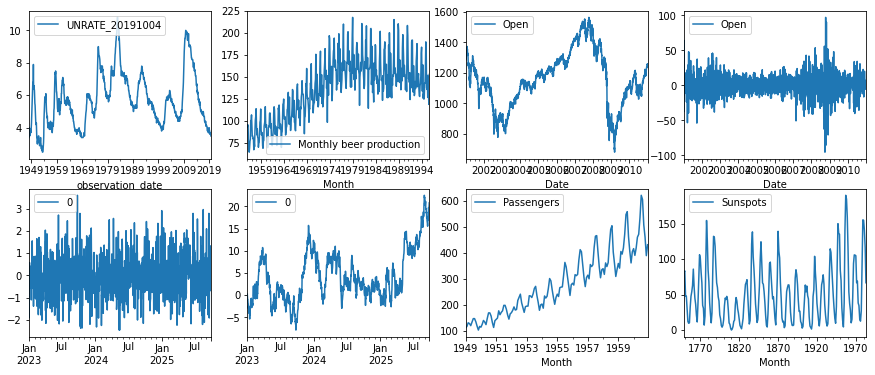

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

df_uschange = pd.read_csv('https://raw.githubusercontent.com/robjhyndman/fpp3package/master/data-raw/US_change/uschange_fpp3_Monthly.txt', delimiter='\t', index_col='observation_date')
df_uschange.index = pd.DatetimeIndex(df_uschange.index)

df_beer = pd.read_csv('https://raw.githubusercontent.com/ejgao/Time-Series-Datasets/master/monthly-beer-production-in-austr.csv', index_col='Month', parse_dates=True)
df_beer.index = pd.DatetimeIndex(df_beer.index)

df_goog = pd.read_csv('https://raw.githubusercontent.com/bharatpurohit97/StockPrediction/master/ReinforcementLearning-YahooFinance/data/%5EGSPC.csv', index_col='Date', parse_dates=True)[['Open']]
df_goog.index = pd.DatetimeIndex(df_goog.index)
df_goog = df_goog.resample('1d').mean().interpolate('linear')

df_air = pd.read_csv('https://raw.githubusercontent.com/Manishms18/Air-Passengers-Time-Series-Analysis/master/Data/AirPassengers.csv', index_col='Month', parse_dates=True)

df_sun = pd.read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly-sunspots.csv', index_col='Month', parse_dates=True)
df_sun.index = pd.DatetimeIndex(df_sun.index)
df_sun = df_sun.resample('y').mean()
df_sun = df_sun.interpolate('linear')

n = 1000
df_rn = pd.DataFrame(np.random.randn(n), index=pd.date_range('2023', periods=n))
df_rw = pd.DataFrame(np.cumsum(np.random.randn(n)), index=pd.date_range('2023', periods=n))

dfs = [df_uschange, df_beer, df_goog, df_goog.diff().iloc[1:], df_rn, df_rw, df_air, df_sun]
names = ['uschange', 'beer', 'goog', 'goog diff', 'RN', 'RW', 'air', 'sunspots']

fig, ax = plt.subplots(2, 4, figsize=(15, 6))
for a, df in zip(ax.ravel(), dfs):
    df.plot(ax=a)

In [2]:
p = 12
mean = lambda x, h: pd.DataFrame(np.tile(x.mean(), h), index=x.index[-1]+np.arange(1, 1+h), columns=x.columns)
seasonal = lambda x, h: pd.DataFrame(np.tile(x.iloc[-p:].values.ravel(), int(p*np.ceil(h/p)))[:h], index=x.index[-1]+np.arange(1, 1+h), columns=x.columns)
naive = lambda x, h: pd.DataFrame(np.tile(x.iloc[-1], h), index=x.index[-1]+np.arange(1, 1+h), columns=x.columns)
forecasters = [naive, mean, seasonal]
forecasters_names = ['naive', 'mean', 'seasonal']

In [3]:
def get_errs(df_tr, forecaster, steps_ahead):
  """
  Returns a pd.DataFrame of dimension (T, steps_ahead) containing the forecast 
  errors, running the forecaster on the input DataFrame df_tr
  """
  errs = {}
  df_tr.reset_index(drop=True, inplace=True)
  for i in np.arange(1, len(df_tr)-steps_ahead):
    y_hat = forecaster(df_tr.iloc[:i], steps_ahead)
    err = df_tr.iloc[i:i+steps_ahead] - y_hat
    errs[df_tr.index[i]] = err.values.ravel()
  return pd.DataFrame(errs).T

errs = get_errs(df, naive, 3)
errs.head(5)

,0,1,2
1,2.466667,-33.266667,-33.125000
2,-35.733333,-35.591667,-52.700000
3,0.141667,-16.966667,-35.441667
4,-17.108333,-35.583333,-38.233333
5,-18.475000,-21.125000,-20.500000


retrieving errs naive on dataset uschange
retrieving errs mean on dataset uschange
retrieving errs seasonal on dataset uschange
retrieving errs naive on dataset beer
retrieving errs mean on dataset beer
retrieving errs seasonal on dataset beer
retrieving errs naive on dataset goog
retrieving errs mean on dataset goog
retrieving errs seasonal on dataset goog
retrieving errs naive on dataset goog diff
retrieving errs mean on dataset goog diff
retrieving errs seasonal on dataset goog diff
retrieving errs naive on dataset RN
retrieving errs mean on dataset RN
retrieving errs seasonal on dataset RN
retrieving errs naive on dataset RW
retrieving errs mean on dataset RW
retrieving errs seasonal on dataset RW
retrieving errs naive on dataset air
retrieving errs mean on dataset air
retrieving errs seasonal on dataset air
retrieving errs naive on dataset sunspots
retrieving errs mean on dataset sunspots
retrieving errs seasonal on dataset sunspots
standard deviations of the errors for step 0:
us

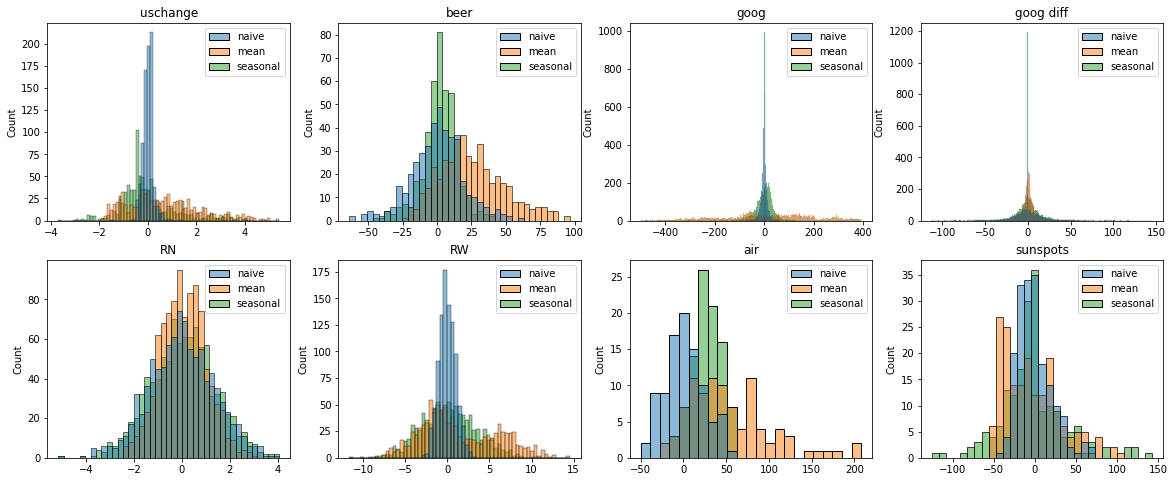

In [4]:
def get_all_errs(dfs, names, forecasters, forecasters_names,steps_ahead=1, test_samples=48, do_plots=True):
  """
  Runs get_errs on all the (dataset,forecasters) tuples and return error 
  matrices and error standard deviations  
  """
  if do_plots:
    fig, ax = plt.subplots(2, 4, figsize=(20, 8))
  stds = {}
  all_errs = {}
  for df, name, a in zip(dfs, names, ax.ravel()):
      errs = {}
      for f, f_name in zip(forecasters, forecasters_names):
          print('retrieving errs {} on dataset {}'.format(f_name, name))
          df_tr = df.iloc[:-test_samples]
          errs[f_name] = get_errs(df_tr, f, steps_ahead)
      all_errs[name] = pd.concat(errs,axis=1)
      stds[name] = all_errs[name].std()
      if do_plots:
        sb.histplot(all_errs[name], ax=a)
        a.set_title(name)
  return all_errs, stds
all_errs, stds = get_all_errs(dfs, names, forecasters, forecasters_names, steps_ahead=1, test_samples=48, do_plots=True)
stds = pd.concat(stds)
print('standard deviations of the errors for step 0:')
print(stds)

###❓Q2 Confidence intervals
Retrieve the theoric confidence intervals for all the datasets for one of the benchmark method. You will need to estimate $\sigma$ from the error distribution you already retrieve. Under normality assumption, you can retrieve the $\alpha\%$ confidence interval knowing the $(1-\alpha)/2 + \alpha$ quantile of the normal distribution. Why?

Use the `norm.ppf` function from scipy.stats to retrieve the quantiles of the standard normal distribution.  

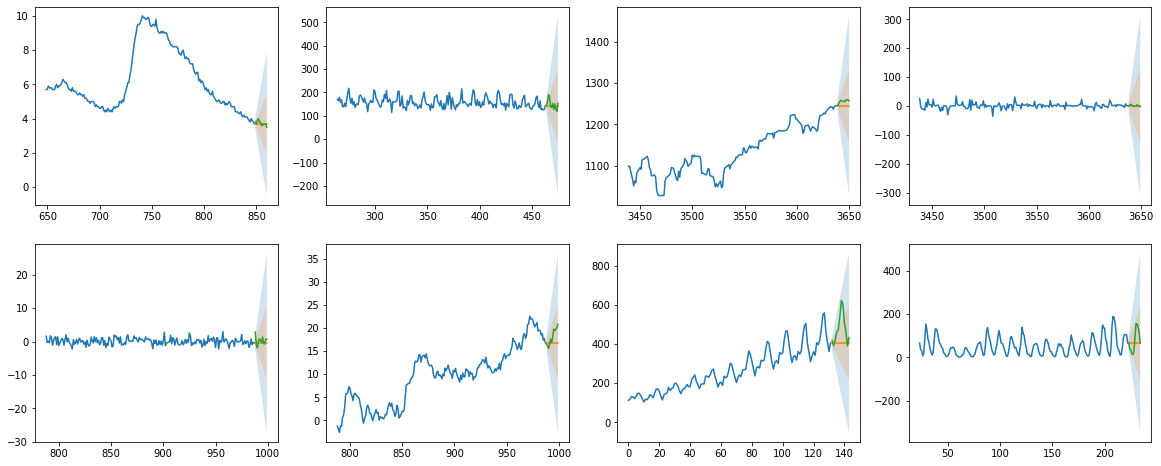

In [6]:

from scipy.stats import norm
get_ci = lambda y, std, alpha: pd.DataFrame(y.values + np.outer((std*np.arange(1, len(y)+1)*norm.ppf((1-alpha)/2 + alpha)), np.array([1, -1])),index=y.index)

steps_ahead = 12
fig, ax = plt.subplots(2, 4, figsize=(20, 8))
for a, df, n in zip(ax.ravel(), dfs, names):
    df.reset_index(drop=True, inplace=True)
    df_tr, df_te = df.iloc[:-steps_ahead], df.iloc[-steps_ahead:]
    y_hat = naive(df_tr, steps_ahead)
    std = stds[n]['naive'].values
    cis_90 = get_ci(y_hat, std, 0.9)
    cis_50 = get_ci(y_hat, std, 0.5)
    a.plot(df_tr.iloc[-200:])
    a.plot(y_hat)
    a.plot(df_te)
    a.fill_between(cis_90.index, *cis_90.values.T, alpha=0.2)
    a.fill_between(cis_50.index, *cis_50.values.T, alpha=0.2)


### ❓Q3 Use the empirical distributions to retrieve the CIs
Instead of using the theorical formula for the quantiles, try to use the historical error distirbution for n steps ahead to retrieve the error quantiles.
Use just one forecasting method, for all the datasets retrieve the error matrices $\epsilon_{t, h}$ where $t$ is the time at which the prediction was done and $h$ is the step ahead.

retrieving errs naive on dataset uschange
retrieving errs naive on dataset beer
retrieving errs naive on dataset goog
retrieving errs naive on dataset goog diff
retrieving errs naive on dataset RN
retrieving errs naive on dataset RW
retrieving errs naive on dataset air
retrieving errs naive on dataset sunspots


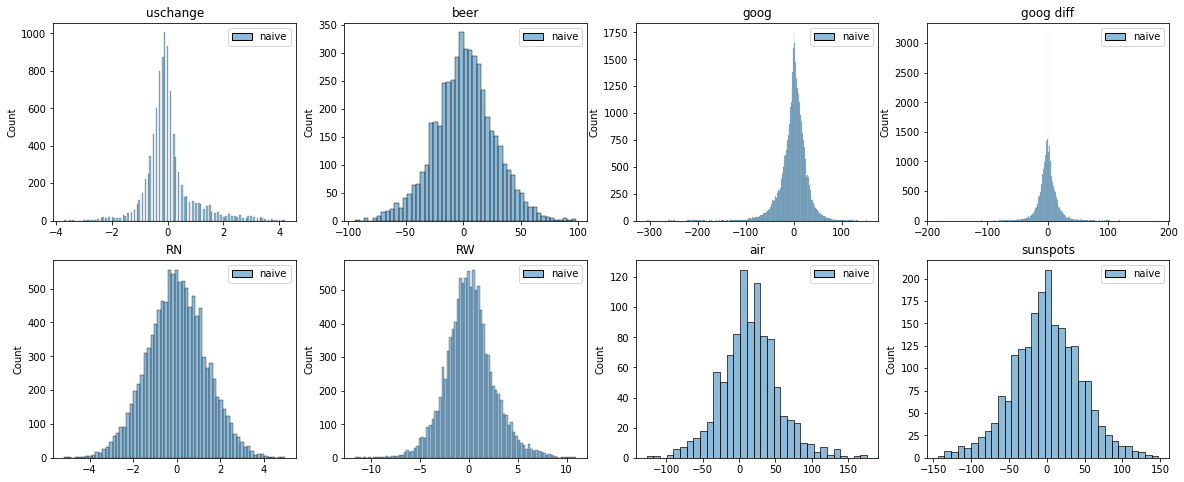

In [7]:
all_errs, stds = get_all_errs(dfs, names, [naive],['naive'], steps_ahead=steps_ahead, test_samples=48, do_plots=True)


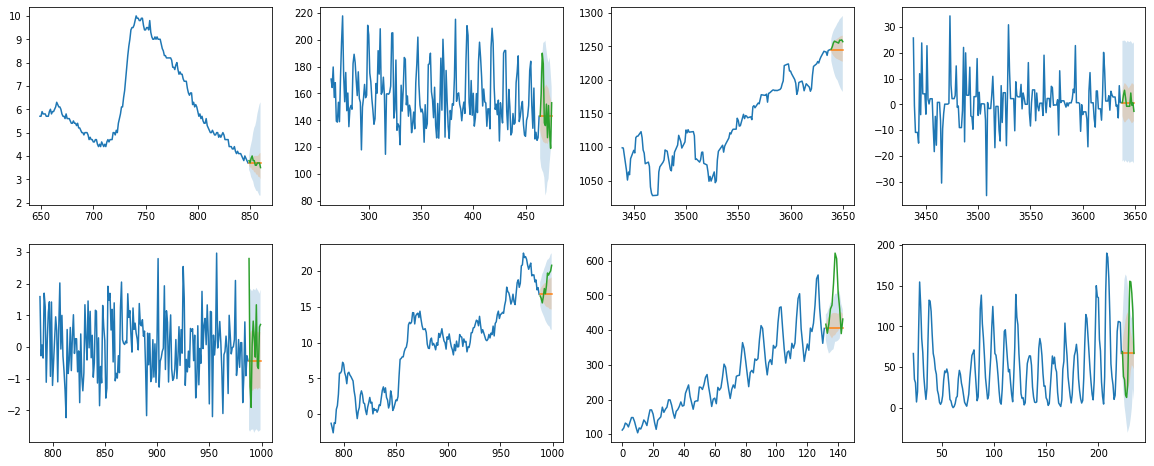

In [8]:
steps_ahead = 12
fig, ax = plt.subplots(2, 4, figsize=(20, 8))
for a, df, n in zip(ax.ravel(), dfs, names):
    df.reset_index(drop=True, inplace=True)
    df_tr, df_te = df.iloc[:-steps_ahead], df.iloc[-steps_ahead:]
    y_hat = naive(df_tr, steps_ahead)
    cis_90 = np.quantile(all_errs[n],[0.05, 0.95], axis=0) + y_hat.values.ravel()
    cis_50 = np.quantile(all_errs[n],[0.25, 0.75], axis=0)+ y_hat.values.ravel()
    a.plot(df_tr.iloc[-200:])
    a.plot(y_hat)
    a.plot(df_te)
    a.fill_between(y_hat.index, *cis_90, alpha=0.2)
    a.fill_between(y_hat.index, *cis_50, alpha=0.2)

### ❓Q4 Generate scenarios 
Instead of plotting the error distributions $\varepsilon_{h}$, just draw n error scenarios at random from the $\epsilon_{t, h}$ matrices and plot them
